
**Install requirements**

In [0]:
if(False):
  #!pip3 install 'torch==1.3.1'
  !pip3 install 'torch==1.4.0'
  !pip3 install 'torchvision==0.5.0'
  !pip3 install 'Pillow-SIMD'
  !pip3 install 'tqdm'


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 35      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10
VAL_FREQUENCY = 2

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

from Caltech101.caltech_dataset11 import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'

In [86]:
def PrepareDataset():
  # Prepare Pytorch train/test Datasets
  train_dataset_Caltech = Caltech(DATA_DIR, split='train',  transform=train_transform)

  train_dataset = deepcopy(train_dataset_Caltech)
  train_dataset.SetTrain()

  val_dataset = train_dataset_Caltech
  val_dataset.SetVal()

  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
  test_dataset.SetTest()

  #Split ad-hoc inside Caltech class
  #train_indexes = []
  #val_indexes = []

  # Check dataset sizes
  print('Train Dataset: {}'.format(len(train_dataset.samples_train)))
  print('Valid Dataset: {}'.format(len(val_dataset.samples_val)))
  print('Train/Valid Dataset Proportion: {} (Required: {})'.format( len(train_dataset.samples_train)/len(val_dataset.samples_val), int(2/1) ) )
  print('Test Dataset: {}'.format(len(test_dataset.samples)))

  return train_dataset, val_dataset, test_dataset
train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 3856
Valid Dataset: 1928
Train/Valid Dataset Proportion: 2.0 (Required: 2)
Test Dataset: 2893


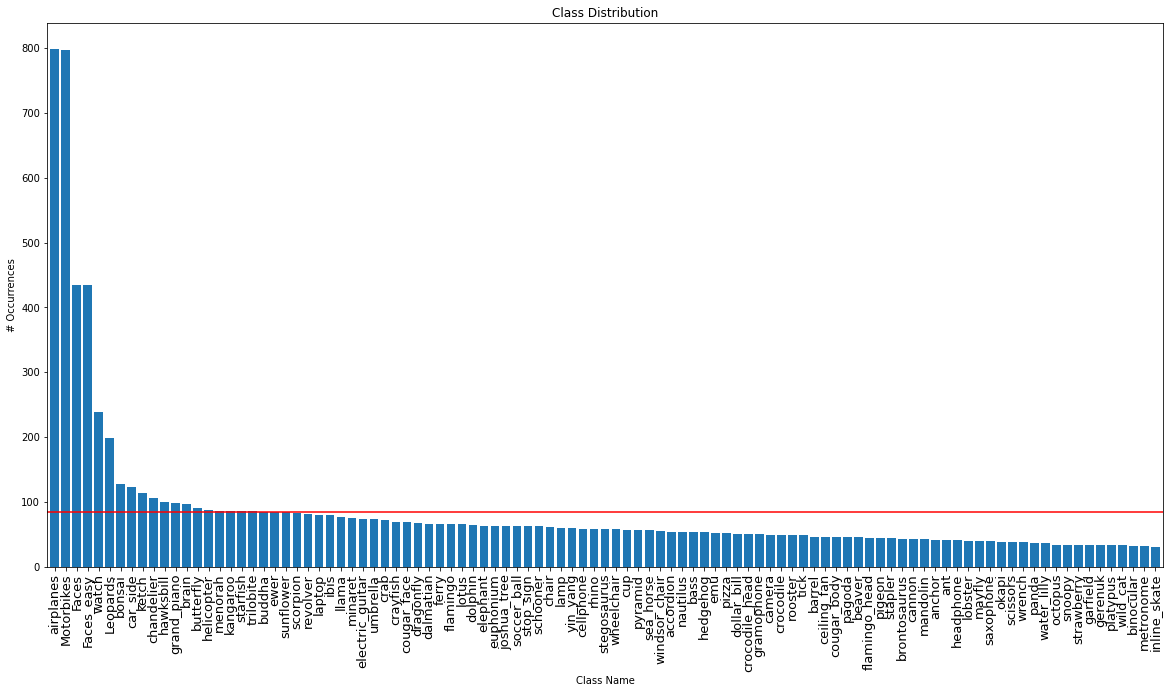

Total Images: 8677
Max # Images in a class: 799
Min # Images in a class: 30
Mean Images for classes: 84.911
STD Images for classes: 117.751


In [94]:
if(True):
  classes_size = {}
  elements = 0
  targets = train_dataset.targets + val_dataset.targets + test_dataset.targets
  class_to_idx = train_dataset.class_to_idx 
  for i in targets:
    class_name = next((name for name, index in class_to_idx.items() if index == i), None)
    elements += 1
    if class_name not in classes_size:
      classes_size[class_name] = 0
    else:
      classes_size[class_name] = classes_size[class_name] + 1

  sorted_classes = dict(sorted(classes_size.items(), key=lambda x: x[1],reverse=True))
  fig, ax = plt.subplots(figsize=(20,10))
  x_pos = np.arange(len(train_dataset.classes))#.getClass()
  ax.set_xticks(x_pos)
  ax.set_xticklabels(list(sorted_classes.keys()),rotation='vertical', fontsize=13)

  plt.axhline(np.mean(list(classes_size.values())), c='r' )

  l , r = plt.xlim()
  value = 0.7
  plt.xlim( l-value, r+value )

  plt.bar(x_pos,sorted_classes.values())
  plt.title('Class Distribution')
  plt.xlabel('Class Name')
  plt.ylabel('# Occurrences')
  plt.show()

  print('Total Images: {}'.format(elements))
  print('Max # Images in a class: {}'.format(max(classes_size.values())))
  print('Min # Images in a class: {}'.format(min(classes_size.values())))
  print('Mean Images for classes: {:.3f}'.format(np.mean(list(classes_size.values()))))
  print('STD Images for classes: {:.3f}'.format(np.std(list(classes_size.values()))))

**Prepare Dataloaders**

In [0]:
def PrepareDataLoaders():
  # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  return train_dataloader, val_dataloader, test_dataloader
train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

In [0]:
def NumParamsToTrain(net):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in net.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
  diff = total_params-total_trainable_params
  print(f'{diff:,} freezed parameters.')
  ratio = total_trainable_params/total_params
  print(f'{ratio:.2f} ratio training/total.')

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [0]:
def Validation(model, dataset, dataloader):
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  model.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in (dataloader):#tqdm
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = model(images)

    loss = criterion(outputs, labels)
    max = 6
    loss_value = loss.item() if loss.item()<max else max

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataset))

  print('*** Validation Accuracy: {} ***'.format(accuracy))

  return (accuracy, loss_value)

**Train**

In [0]:
def Training(net):
  # By default, everything is loaded to cpu
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  current_epoch = 0
  loss_value = 0
  # Start iterating over the epochs

  #Test and Validation Loss and Accuracy
  train = []
  valid = []
  best_acc = -99999999
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects = 0
    # Iterate over the dataset
    for images, labels in train_dataloader:
      #net.train(True)
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      max = 6
      loss_value = loss.item() if loss.item()<max else max

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format( current_step, loss_value ))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Calculate Accuracy
    accuracy = running_corrects / float(len(train_dataset))

    #Store training values each epoch
    train.append( (accuracy, loss_value) )

    
    #Evaluate the model each epoch and store the values
    if current_epoch % VAL_FREQUENCY == 0:
      valid.append( Validation(net,val_dataset,val_dataloader) )

      #Get model with best accuracy
      if(best_acc<accuracy):
        best_acc = accuracy

    current_epoch += 1

    # Step the scheduler
    scheduler.step()

  return net, train, valid, best_acc

In [101]:
NumParamsToTrain(net)

57,417,637 total parameters.
57,417,637 training parameters.
0 freezed parameters.
1.00 ratio training/total.


In [102]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614983081817627
Step 10, Loss 4.614505290985107


KeyboardInterrupt: ignored

In [0]:
print('Best accuracy on Validation set {}'.format(best_acc))
_ = Validation(net, val_dataset, val_dataloader)

Best accuracy on Validation set 0.10399377593360996
*** Validation Accuracy: 0.09232365145228216 ***


In [0]:
def PlotAccuracyLoss(train, valid, meta=''):
  acc_train = np.array(train)[:,0]
  acc_valid = np.array(valid)[:,0]

  loss_train = np.array(train)[:,1]
  loss_valid = np.array(valid)[:,1]

  epoch_train = [i for i in range(len(acc_train))]
  epoch_val = [i*VAL_FREQUENCY for i in range(len(acc_valid))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_train = '#ff0000'
  color_val = '#00ff00'

  ax[0].plot(epoch_train,loss_train,color=color_train)
  ax[0].scatter(epoch_train,loss_train,marker='s',s=size,color=color_train)
  ax[0].plot(epoch_val,loss_valid,color=color_val)
  ax[0].scatter(epoch_val,loss_valid,marker='s',s=size,color=color_val)
  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')

  ax[1].plot(epoch_train,acc_train,color=color_train)
  ax[1].scatter(epoch_train,acc_train,marker='s',s=size,color=color_train)
  ax[1].plot(epoch_val,acc_valid,color=color_val)
  ax[1].scatter(epoch_val,acc_valid,marker='s',s=size,color=color_val)
  ax[1].set_title('Accuracy Graph')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

  fig.suptitle(meta)
  plt.legend(["Train", "Validation"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  print('Min Loss: Train: {:.6f}, Val: {:.6f}'.format( min(loss_train), min(loss_valid) ))
  print('Max Accuracy: Train: {:.6f}, Val: {:.6f}'.format( max(acc_train), max(acc_valid) ))

In [0]:
meta = 'Training from Scratch: LR= {} and Optimazer= SGD'.format(LR)
PlotAccuracyLoss(test,valid, meta)

NameError: ignored

**Test**

In [0]:
if(False):
  #Old version
  '''
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  '''
  #New version:
  result = Validation(net,test_dataset,test_dataloader)

*** Validation Accuracy: 0.09194607673695127 ***


Training using different parameters

---  Training with LR = 0.01 and Optimazer = Adam  ---
Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.617311954498291
Step 10, Loss 6
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 4.598507404327393
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 6
Step 40, Loss 6
*** Validation Accuracy: 0.007780082987551867 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 5.2108564376831055
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 4.928414821624756
Step 70, Loss 6
*** Validation Accuracy: 0.01037344398340249 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 4.615580081939697
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 4.614144325256348
Step 100, Loss 4.6052069664001465
*** Validation Accuracy: 0.011410788381742738 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 4.575087070465088
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 4.541738510131836
Step 130, Loss 6
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 10/35, LR = [0.01]
Step 140, Loss 4.479869365692139
Starting epoch 11/35, LR = [0.01]
Step 150, Los

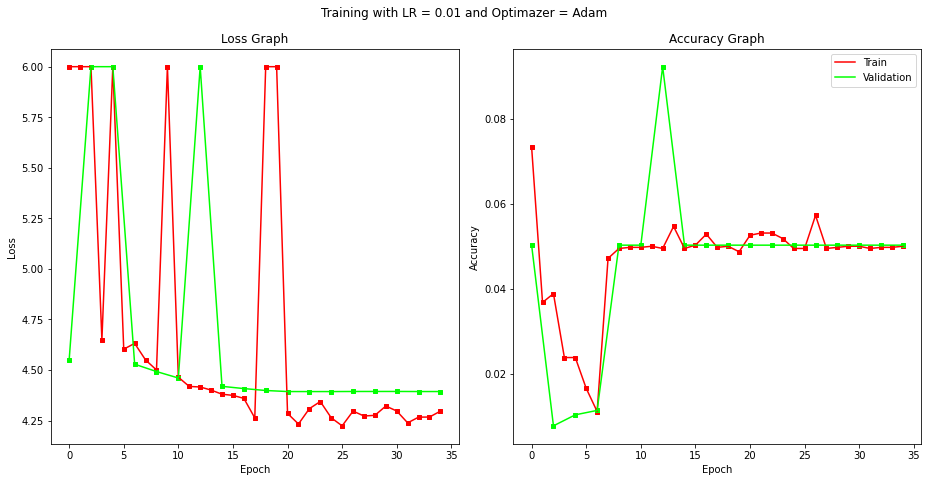

Min Loss: Train: 4.223996, Val: 4.393470
Max Accuracy: Train: 0.073392, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615792751312256
Step 10, Loss 6
*** Validation Accuracy: 0.009854771784232365 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 6
Step 40, Loss 6
*** Validation Accuracy: 0.012966804979253113 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 6
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 5.32397985458374
Step 70, Loss 5.080368518829346
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 4.66340446472168
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 4.413944244384766
Step 100, Loss 4.361103057861328
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 4.18173885345459
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 4.286628723144531
Step 130, Loss 4.2247490882873535
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/35, LR = [0.01]
Step 140, Loss 4.271127223968506
Starting epoch 11/35, LR = [0.01]
Step 150, Loss 6
S

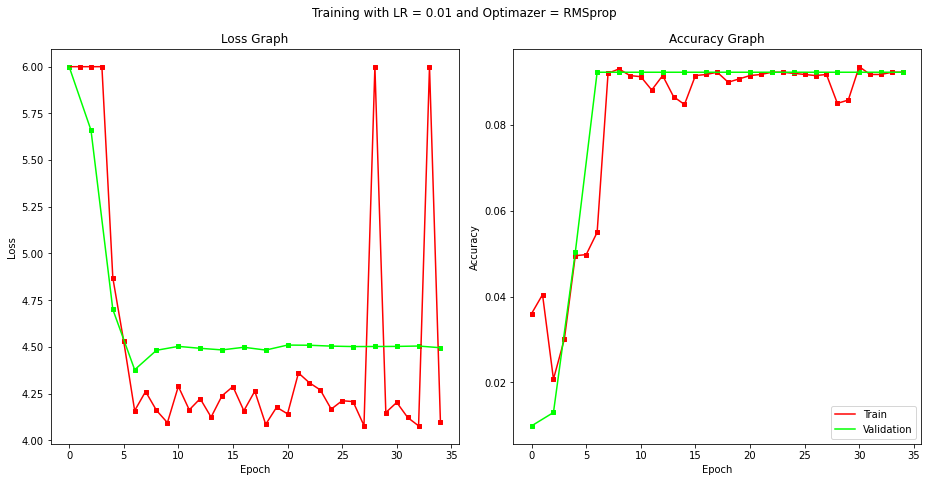

Min Loss: Train: 4.077237, Val: 4.377572
Max Accuracy: Train: 0.093620, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614846706390381
Step 10, Loss 4.603967189788818
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 4.582757949829102
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 4.559642314910889
Step 40, Loss 4.530513763427734
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 4.427194595336914
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 4.281826972961426
Step 70, Loss 4.314146518707275
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 4.128175258636475
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 4.156094551086426
Step 100, Loss 4.142775058746338
*** Validation Accuracy: 0.13641078838174273 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 4.087480545043945
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 3.880918264389038
Step 130, Loss 4.069236755371094
*** Validation Accuracy: 0.2033195020746888 ***
Starting epoch 10/35, LR = [0.01]
Step 14

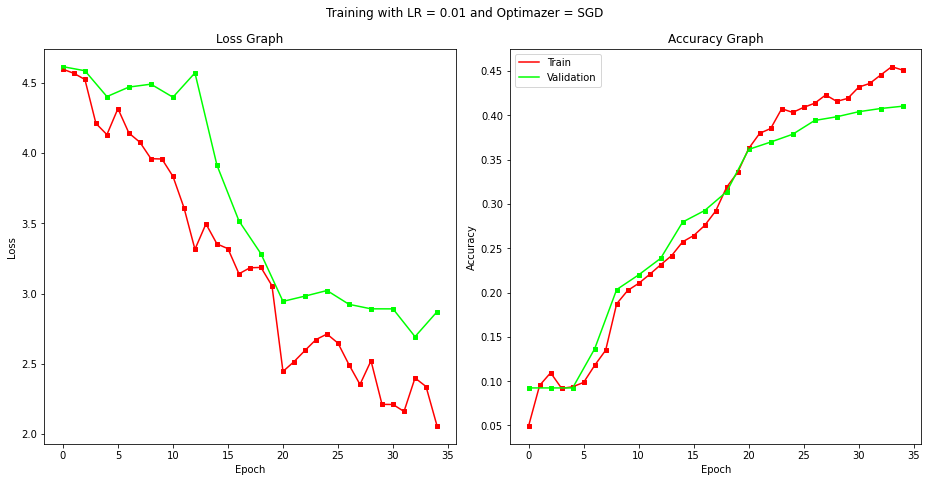

Min Loss: Train: 2.058413, Val: 2.693132
Max Accuracy: Train: 0.454876, Val: 0.410270
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.613314151763916
Step 10, Loss 4.479166030883789
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 4.245123386383057
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 4.15950345993042
Step 40, Loss 4.188518524169922
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 4.125724792480469
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 4.088485240936279
Step 70, Loss 3.699230194091797
*** Validation Accuracy: 0.17738589211618258 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 3.6864712238311768
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 3.455470561981201
Step 100, Loss 3.4829459190368652
*** Validation Accuracy: 0.2857883817427386 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 3.0477075576782227
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 3.022764205932617
Step 130, Loss 2.9770593643188477
*** Validation Accuracy: 0.31950207468879666 ***
Starting epoch 10/35, LR = [0.

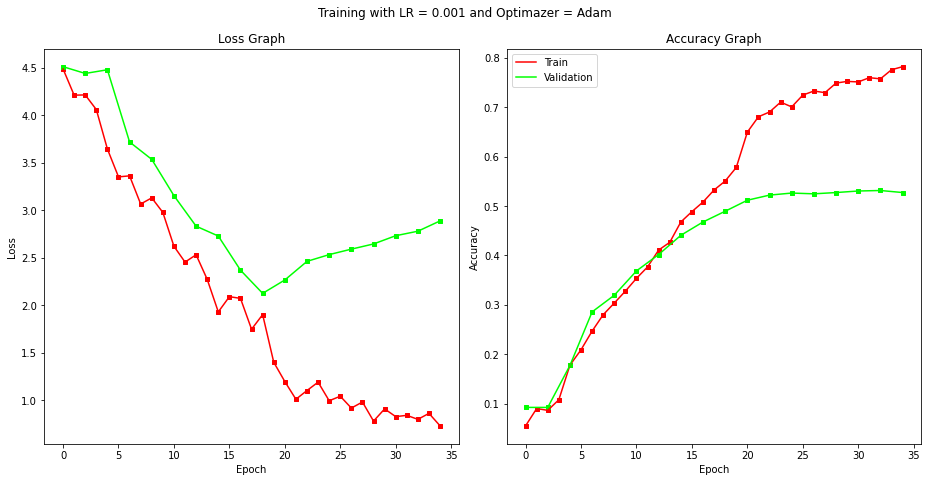

Min Loss: Train: 0.731751, Val: 2.125531
Max Accuracy: Train: 0.782417, Val: 0.531639
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.61423397064209
Step 10, Loss 6
*** Validation Accuracy: 0.029045643153526972 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 6
Step 40, Loss 6
*** Validation Accuracy: 0.008817427385892116 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 6
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 6
Step 70, Loss 4.805863857269287
*** Validation Accuracy: 0.023340248962655602 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 4.598348140716553
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 4.577571868896484
Step 100, Loss 4.556041240692139
*** Validation Accuracy: 0.022821576763485476 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 4.489392280578613
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 4.442059516906738
Step 130, Loss 4.40833044052124
*** Validation Accuracy: 0.09180497925311204 ***
Starting epoch 10/35, LR = [0.001]
Step 140, Loss 4.379403591156006
Starting epoch 11/35, LR = [0.001]
Step 150, Loss 4.372388

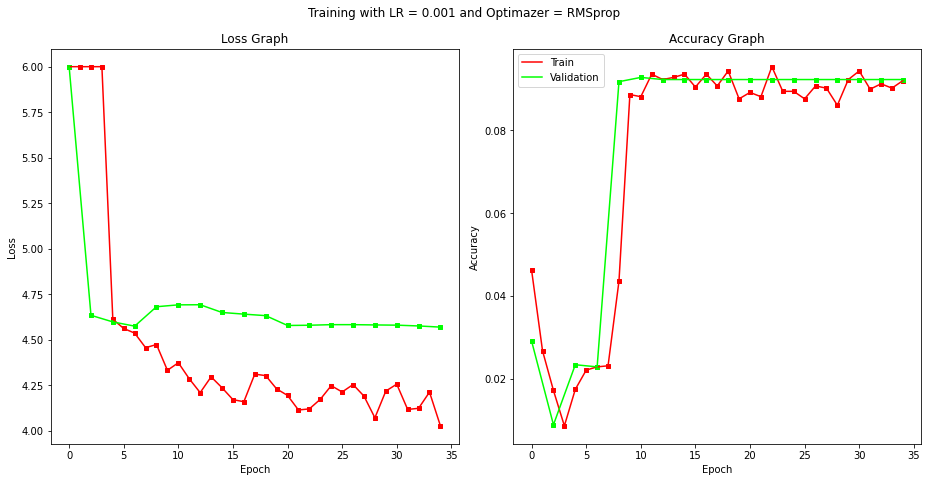

Min Loss: Train: 4.027620, Val: 4.569804
Max Accuracy: Train: 0.095436, Val: 0.092842
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614518165588379
Step 10, Loss 4.612405776977539
*** Validation Accuracy: 0.0036307053941908715 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 4.611848831176758
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 4.607398986816406
Step 40, Loss 4.606614589691162
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 4.604701995849609
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 4.599761009216309
Step 70, Loss 4.598306655883789
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 4.592050552368164
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 4.5894598960876465
Step 100, Loss 4.589550495147705
*** Validation Accuracy: 0.09595435684647304 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 4.580794334411621
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 4.587626934051514
Step 130, Loss 4.575706481933594
*** Validation Accuracy: 0.14678423236514523 ***
Starting epoch 10/35, LR = [0

In [0]:
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

scores_scratch = {}
for lr in lr_values:
  for op in optimazers:

    meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
    print('---  {}  ---'.format(meta))

    net_scratch = alexnet()
    net_scratch.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net_scratch.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    net_scratch, test, valid, best_acc = Training(net_scratch)
    PlotAccuracyLoss(test,valid,meta=meta)

    scores_scratch[(lr,op)] = (test,valid, net)

    print('---  --- ---  ---')
    print()


In [0]:
def GetMaxAcc(scores,printAll=False):
  values = dict()
  for k,v in scores.items():
    if(printAll):
      print(k)

    count = 0
    values[k] = []
    train = (0,0)
    val = (0,0)
    for i in v:
      if(count==0):
        train = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          #print('Train: Min Loss {}'.format(train[0]))
          print('Train: Max Acc {}'.format(train[1]))
      elif(count==1):
        val = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          print('Val: Min Loss {}'.format(val[0]))
          print('Val: Max Acc {}'.format(val[1]))
      count += 1
    values[k].append(train)
    values[k].append(val)
    if(printAll):
      print('---  ----  ----')
  return values

In [0]:
def SketchHeatMap(scores,trainAcc=False):
  import seaborn as sns
  score = GetMaxAcc(scores)

  keys = list(score.keys())
  x = set(i[0] for i in keys)
  x = sorted(x,reverse=True)
  y = set(i[1] for i in keys)

  meta = ''
  if (trainAcc):
    index = 0
    meta = 'Training'
  else: 
    index = 1
    meta = 'Validation'

  values = []
  for v in list(score.values()):
    count = 0
    for i in v:
      if(count==index):
        values.append(i[1]) 
      count += 1

  v = [[0,0,0],[0,0,0],[0,0,0]]
  for i in range(3):
    for j in range(3):
      v[i][j] = values[3*i+j]

  pd_scores = pd.DataFrame(v, index=x, columns=y)
  sns.heatmap(pd_scores, vmin=0, vmax=1, linewidths=.1, annot=True,xticklabels='auto', yticklabels='auto')
  plt.xlabel("Optimizer")
  plt.ylabel("Learning Rate")
  plt.title('HeatMap {} Accuracy'.format(meta))
  plt.show()

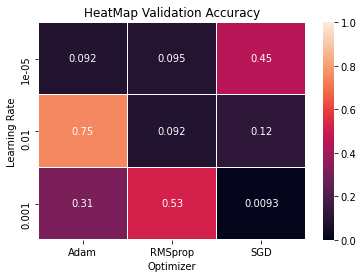

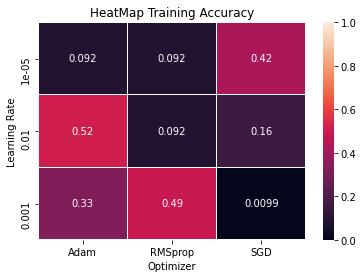

In [0]:
SketchHeatMap(scores)
SketchHeatMap(scores,True)

Pre-Trainined net

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 3856
Valid Dataset: 1928
Train/Valid Dataset Proportion: 2.0 (Required: 2)
Test Dataset: 2893


---  Training with LR = 0.01 and Optimazer = Adam  ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.7972731590271
Step 10, Loss 6
*** Validation Accuracy: 0.022821576763485476 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 6
Step 40, Loss 4.804847717285156
*** Validation Accuracy: 0.01037344398340249 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 4.775225639343262
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 4.614400863647461
Step 70, Loss 4.4866108894348145
*** Validation Accuracy: 0.01037344398340249 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 4.320399284362793
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 6
Step 100, Loss 5.162583351135254
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 4.571782112121582
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 4.5702714920043945
Step 130, Loss 5.824456214904785
*** Validation Accuracy: 0.0954356846473029 ***
Starting epoch 10/35, LR = [0.01]
Step 140, Loss 4.543302536010742
Starting epoch 11/35, LR = [0.01]
Ste

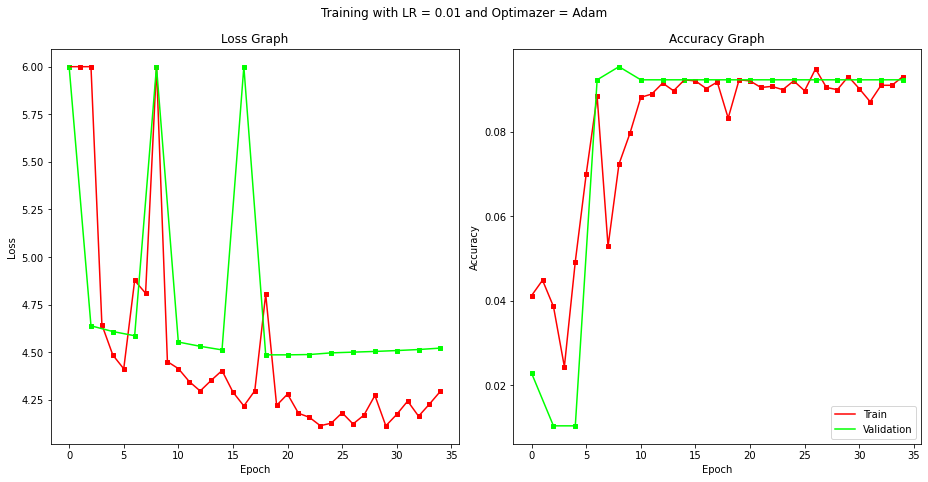

Min Loss: Train: 4.113863, Val: 4.486648
Max Accuracy: Train: 0.094917, Val: 0.095436
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.684851169586182
Step 10, Loss 6
*** Validation Accuracy: 0.009854771784232365 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 6
Step 40, Loss 6
*** Validation Accuracy: 0.005186721991701245 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 6
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 6
Step 70, Loss 6
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 6
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 6
Step 100, Loss 6
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 6
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 6
Step 130, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/35, LR = [0.01]
Step 140, Loss 6
Starting epoch 11/35, LR = [0.01]
Step 150, Loss 6
Step 160, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 12/35, LR = [0.01]
Step 170, Loss 6
Starting epoch 13/35, LR 

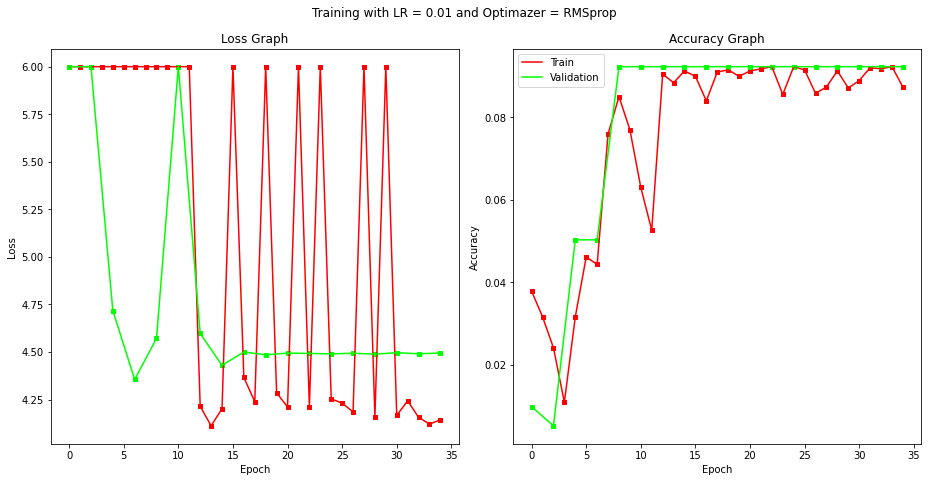

Min Loss: Train: 4.111554, Val: 4.355427
Max Accuracy: Train: 0.092324, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/35, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.808969497680664
Step 10, Loss 2.1276047229766846
*** Validation Accuracy: 0.7028008298755186 ***
Starting epoch 2/35, LR = [0.01]
Step 20, Loss 0.6826868057250977
Starting epoch 3/35, LR = [0.01]
Step 30, Loss 0.4104446768760681
Step 40, Loss 0.23476287722587585
*** Validation Accuracy: 0.8029045643153527 ***
Starting epoch 4/35, LR = [0.01]
Step 50, Loss 0.1874283254146576
Starting epoch 5/35, LR = [0.01]
Step 60, Loss 0.13094934821128845
Step 70, Loss 0.09488316625356674
*** Validation Accuracy: 0.8475103734439834 ***
Starting epoch 6/35, LR = [0.01]
Step 80, Loss 0.08710688352584839
Starting epoch 7/35, LR = [0.01]
Step 90, Loss 0.06023988500237465
Step 100, Loss 0.016989491879940033
*** Validation Accuracy: 0.8532157676348547 ***
Starting epoch 8/35, LR = [0.01]
Step 110, Loss 0.027523864060640335
Starting epoch 9/35, LR = [0.01]
Step 120, Loss 0.007578011602163315
Step 130, Loss 0.03366173431277275
*** Validation Accuracy: 0.8464730290456431 ***
Starting epoch 10/35

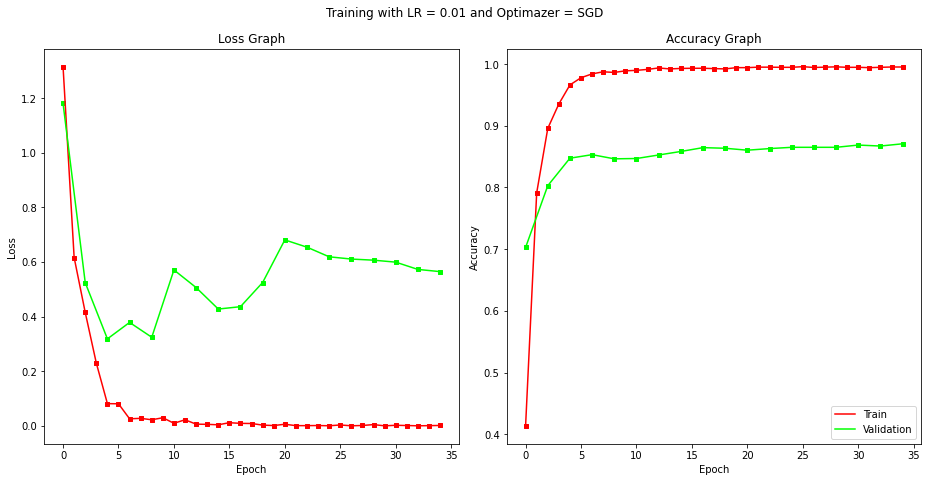

Min Loss: Train: 0.000591, Val: 0.318930
Max Accuracy: Train: 0.995851, Val: 0.870851
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.79547119140625
Step 10, Loss 4.286026477813721
*** Validation Accuracy: 0.29149377593361 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 2.8444342613220215
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 2.503286838531494
Step 40, Loss 1.9695278406143188
*** Validation Accuracy: 0.5570539419087137 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 1.3653128147125244
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 0.9963337779045105
Step 70, Loss 0.9757052063941956
*** Validation Accuracy: 0.6664937759336099 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 0.5821112394332886
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 0.3437650501728058
Step 100, Loss 0.4598347246646881
*** Validation Accuracy: 0.7162863070539419 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 0.2830219566822052
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 0.24467988312244415
Step 130, Loss 0.29903990030288696
*** Validation Accuracy: 0.7359958506224067 ***
Starting epoch 10/35, LR = 

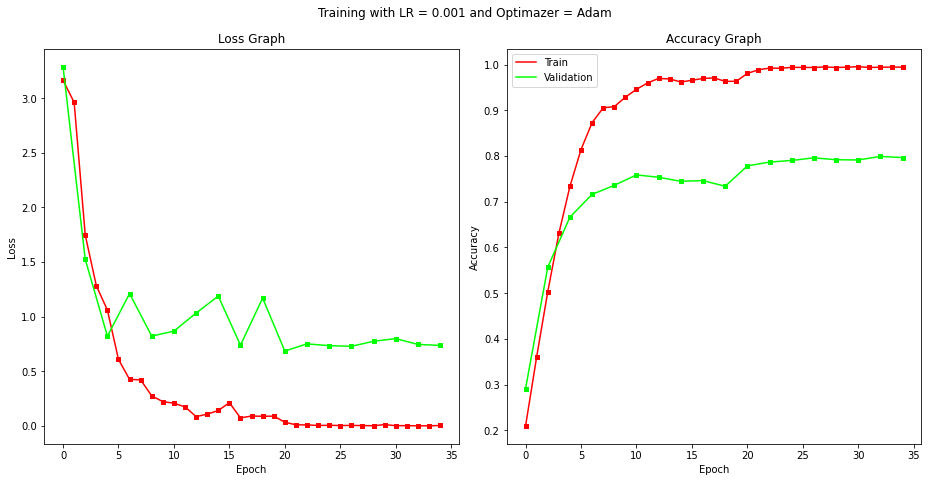

Min Loss: Train: 0.000688, Val: 0.685281
Max Accuracy: Train: 0.995591, Val: 0.799274
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.726895809173584
Step 10, Loss 6
*** Validation Accuracy: 0.05186721991701245 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 6
Step 40, Loss 6
*** Validation Accuracy: 0.006742738589211619 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 6
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 6
Step 70, Loss 6
*** Validation Accuracy: 0.007261410788381743 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 4.653576374053955
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 6
Step 100, Loss 6
*** Validation Accuracy: 0.012448132780082987 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 4.591916084289551
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 4.518179893493652
Step 130, Loss 4.602260589599609
*** Validation Accuracy: 0.050311203319502076 ***
Starting epoch 10/35, LR = [0.001]
Step 140, Loss 4.451058864593506
Starting epoch 11/35, LR = [0.001]
Step 150, Loss 5.378818511962891
Step 160, Loss 5.029704570770264
***

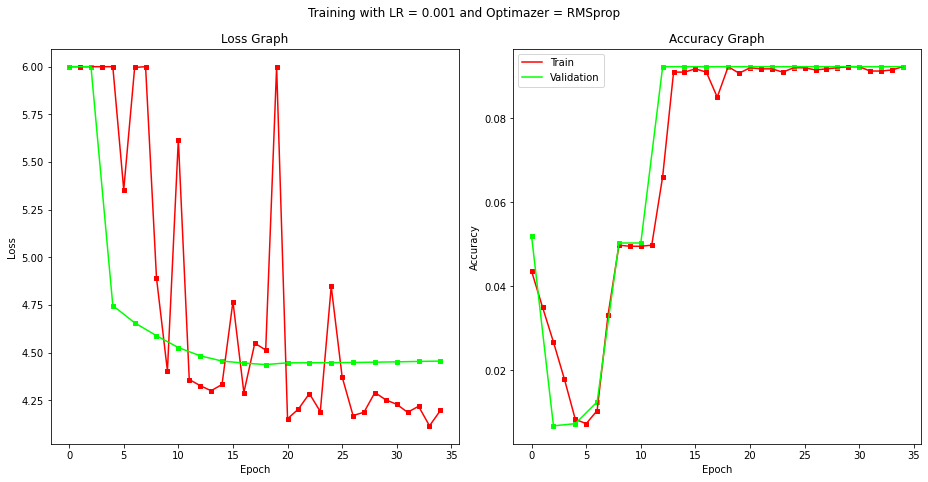

Min Loss: Train: 4.115886, Val: 4.437332
Max Accuracy: Train: 0.092324, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.843282699584961
Step 10, Loss 3.547844409942627
*** Validation Accuracy: 0.3392116182572614 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 2.5293233394622803
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 2.1705570220947266
Step 40, Loss 1.533319354057312
*** Validation Accuracy: 0.6825726141078838 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 0.9748598337173462
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 0.6276099681854248
Step 70, Loss 0.6217719316482544
*** Validation Accuracy: 0.783195020746888 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 0.5874403119087219
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 0.27083390951156616
Step 100, Loss 0.2544099986553192
*** Validation Accuracy: 0.8335062240663901 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 0.23630942404270172
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 0.2173512578010559
Step 130, Loss 0.2526308596134186
*** Validation Accuracy: 0.8314315352697096 ***
Starting epoch 10/35, LR 

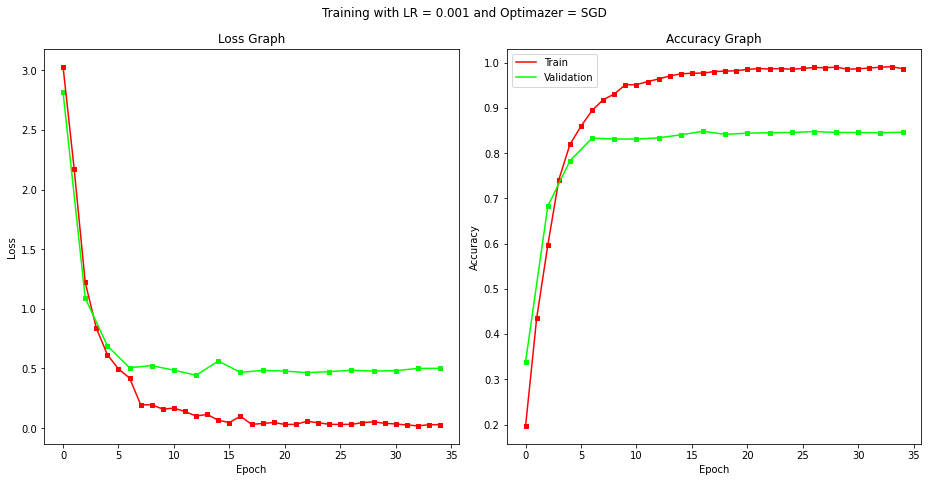

Min Loss: Train: 0.018996, Val: 0.443116
Max Accuracy: Train: 0.991442, Val: 0.848548
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
Starting epoch 1/35, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.863090991973877
Step 10, Loss 4.37054443359375
*** Validation Accuracy: 0.21317427385892115 ***
Starting epoch 2/35, LR = [1e-05]
Step 20, Loss 4.069002628326416
Starting epoch 3/35, LR = [1e-05]
Step 30, Loss 3.471235752105713
Step 40, Loss 3.3487324714660645
*** Validation Accuracy: 0.31690871369294604 ***
Starting epoch 4/35, LR = [1e-05]
Step 50, Loss 3.016180992126465
Starting epoch 5/35, LR = [1e-05]
Step 60, Loss 2.8160667419433594
Step 70, Loss 2.406687021255493
*** Validation Accuracy: 0.4756224066390041 ***
Starting epoch 6/35, LR = [1e-05]
Step 80, Loss 2.150289297103882
Starting epoch 7/35, LR = [1e-05]
Step 90, Loss 1.9206786155700684
Step 100, Loss 1.7046384811401367
*** Validation Accuracy: 0.6146265560165975 ***
Starting epoch 8/35, LR = [1e-05]
Step 110, Loss 1.35102379322052
Starting epoch 9/35, LR = [1e-05]
Step 120, Loss 1.2391494512557983
Step 130, Loss 1.0029795169830322
*** Validation Accuracy: 0.7126556016597511 ***
Starting epoch 10/35, LR = [1e-

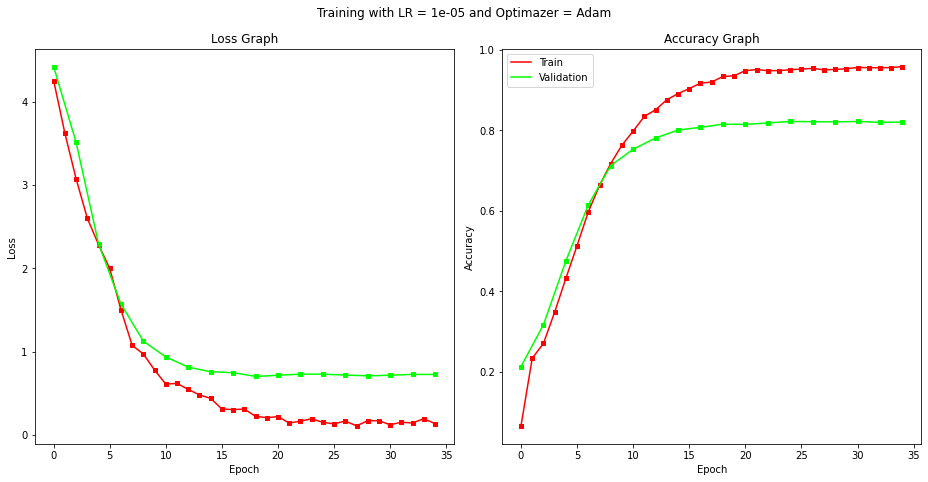

Min Loss: Train: 0.109742, Val: 0.702645
Max Accuracy: Train: 0.958247, Val: 0.822095
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
Starting epoch 1/35, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.842136383056641
Step 10, Loss 2.411228895187378
*** Validation Accuracy: 0.6530082987551867 ***
Starting epoch 2/35, LR = [1e-05]
Step 20, Loss 0.8187402486801147
Starting epoch 3/35, LR = [1e-05]
Step 30, Loss 0.4995836019515991
Step 40, Loss 0.40893876552581787
*** Validation Accuracy: 0.8376556016597511 ***
Starting epoch 4/35, LR = [1e-05]
Step 50, Loss 0.14934183657169342
Starting epoch 5/35, LR = [1e-05]
Step 60, Loss 0.0698074996471405
Step 70, Loss 0.09075747430324554
*** Validation Accuracy: 0.854253112033195 ***
Starting epoch 6/35, LR = [1e-05]
Step 80, Loss 0.029168209061026573
Starting epoch 7/35, LR = [1e-05]
Step 90, Loss 0.05135761946439743
Step 100, Loss 0.018827877938747406
*** Validation Accuracy: 0.858402489626556 ***
Starting epoch 8/35, LR = [1e-05]
Step 110, Loss 0.029216663911938667
Starting epoch 9/35, LR = [1e-05]
Step 120, Loss 0.0039003556594252586
Step 130, Loss 0.005004299804568291
*** Validation Accuracy: 0.8604771784232366 ***
Starting epo

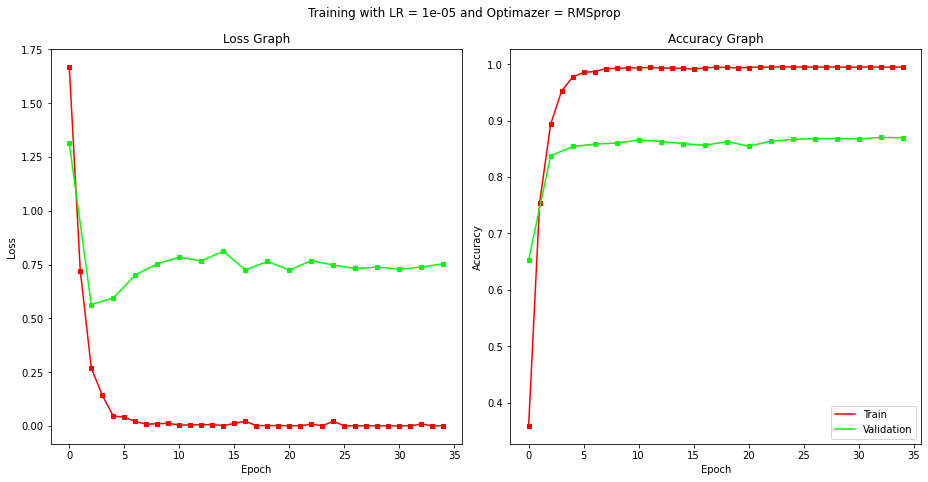

Min Loss: Train: 0.000513, Val: 0.564287
Max Accuracy: Train: 0.995851, Val: 0.870332
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
Starting epoch 1/35, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.765730381011963
Step 10, Loss 4.754080772399902
*** Validation Accuracy: 0.011929460580912862 ***
Starting epoch 2/35, LR = [1e-05]
Step 20, Loss 4.762371063232422
Starting epoch 3/35, LR = [1e-05]
Step 30, Loss 4.672550201416016
Step 40, Loss 4.487756252288818
*** Validation Accuracy: 0.06483402489626557 ***
Starting epoch 4/35, LR = [1e-05]
Step 50, Loss 4.532866477966309
Starting epoch 5/35, LR = [1e-05]
Step 60, Loss 4.420915603637695
Step 70, Loss 4.446121692657471
*** Validation Accuracy: 0.15093360995850622 ***
Starting epoch 6/35, LR = [1e-05]
Step 80, Loss 4.350058555603027
Starting epoch 7/35, LR = [1e-05]
Step 90, Loss 4.2702789306640625
Step 100, Loss 4.139052867889404
*** Validation Accuracy: 0.21524896265560167 ***
Starting epoch 8/35, LR = [1e-05]
Step 110, Loss 4.097802639007568
Starting epoch 9/35, LR = [1e-05]
Step 120, Loss 4.253241062164307
Step 130, Loss 3.985740900039673
*** Validation Accuracy: 0.2391078838174274 ***
Starting epoch 10/35, LR = [1e-

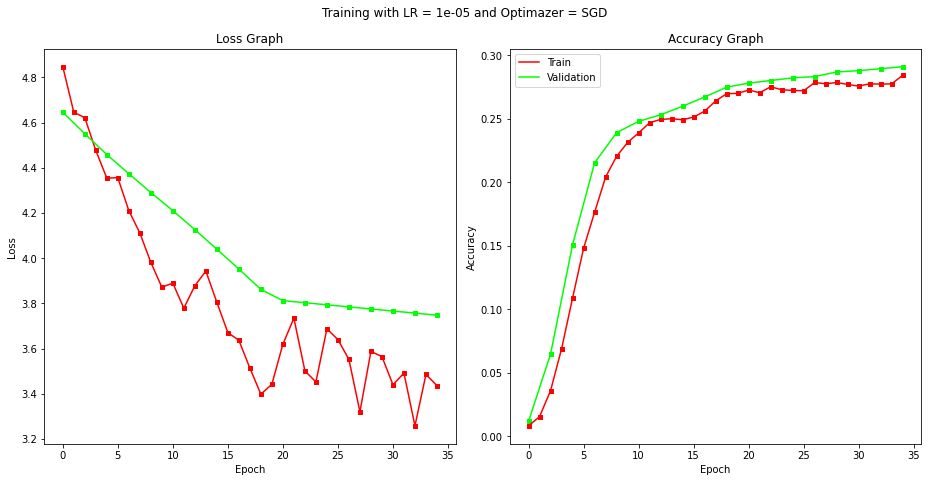

Min Loss: Train: 3.258140, Val: 3.747771
Max Accuracy: Train: 0.284232, Val: 0.290975
---  --- ---  ---



In [0]:
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

scores = {}
for lr in lr_values:
  for op in optimazers:

    meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
    print('---  {}  ---'.format(meta))

    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    net, test, valid, best_acc = Training(net)
    PlotAccuracyLoss(test,valid,meta=meta)

    scores[(lr,op)] = (test, valid, net)

    print('---  --- ---  ---')
    print()


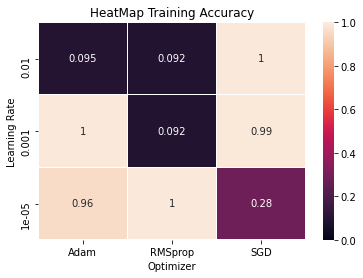

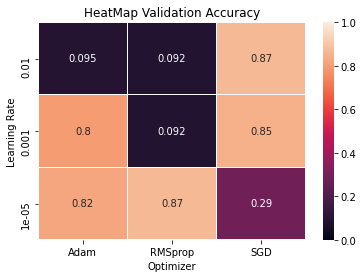

In [0]:
SketchHeatMap(scores,True)
SketchHeatMap(scores)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.733957290649414
Step 10, Loss 3.3763372898101807
Step 20, Loss 2.770613670349121
Step 30, Loss 2.305293560028076
Step 40, Loss 2.559154748916626
Step 50, Loss 1.153554081916809
Step 60, Loss 1.5482194423675537
Step 70, Loss 1.5712007284164429
Step 80, Loss 0.996820330619812
Step 90, Loss 1.03520929813385
Step 100, Loss 1.1759743690490723
Step 110, Loss 1.0116676092147827
*** Validation Accuracy: 0.79201244813278 ***
Starting epoch 2/25, LR = [0.001]
Step 120, Loss 0.47110411524772644
Step 130, Loss 0.5417220592498779
Step 140, Loss 0.5097166895866394
Step 150, Loss 0.34221386909484863
Step 160, Loss 0.33942845463752747
Step 170, Loss 0.3430001139640808
Step 180, Loss 0.6529397368431091
Step 190, Loss 0.3624657988548279
Step 200, Loss 0.7227727770805359
Step 210, Loss 0.421843558549881
Step 220, Loss 0.40746748447418213
Step 230, Loss 0.26633894443511963
Starting epoch 3/25, LR = [0.001]
Step 240, Loss 0.09410157799720764
Step 250, Loss 0.2350466102361679
Step 260, Loss 0

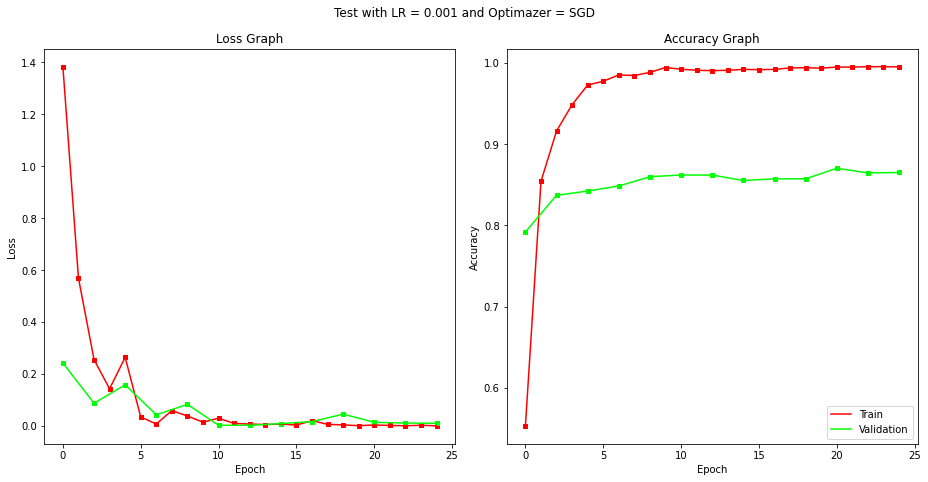

Min Loss: Train: 0.000316, Val: 0.002425
Max Accuracy: Train: 0.995332, Val: 0.870332


In [0]:
if(False):
  net = alexnet(pretrained=True)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net, test, valid, best_acc = Training(net)
  meta = 'Test with LR = {} and Optimazer = {}'.format(best_lr,best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
#Update NUM_EPOCHS since RMSprop seems to converge before 15/20 epochs
NUM_EPOCHS = 25
best_lr = 0.00001
best_opti = 'RMSprop'

*** Validation Accuracy: 0.8727964051157967 ***


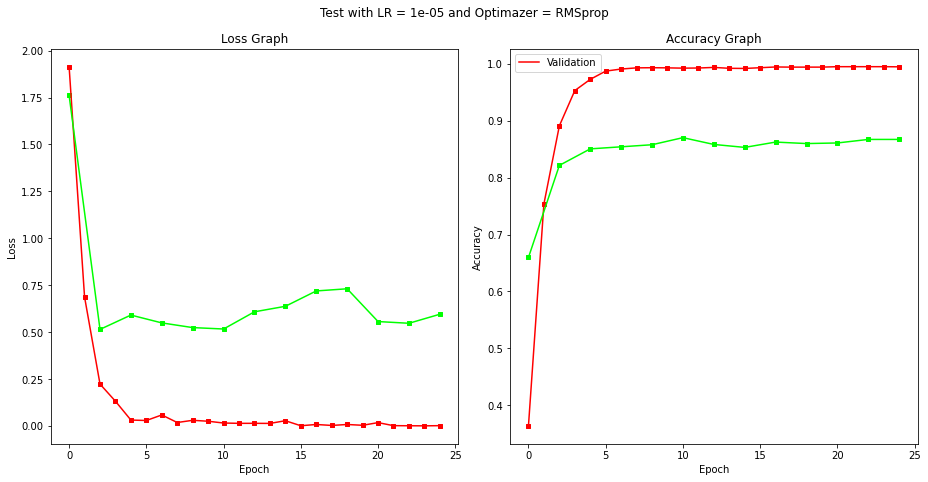

Min Loss: Train: 0.001010, Val: 0.514789
Max Accuracy: Train: 0.995073, Val: 0.870332


In [0]:
#Test best params on the test set
net_best = net #scores[(best_lr,best_opti)][3]
result = Validation(net_best,test_dataset,test_dataloader)

Pre-Trainined net (Fixed CNN)

In [0]:
def FreezeNetwork(net, freeze=0):
  if(freeze!=0 and freeze!= 2):
    print('ERROR INPUT!! Received freeze = {} ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
  else:
    #Set the training for all layers to False
    #freeze: 0 -> freeze FC, 2 -> freeze CNN
    count = 0
    for child in net.children():
      if(count==freeze):#count==freeze
        print('Freezing: {}. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
        for param in child.parameters():
              param.requires_grad = False
        exit
      count += 1
  NumParamsToTrain(net)
  return net

In [0]:
net = alexnet(pretrained=True)

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

net = FreezeNetwork(net,2)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Freezing: 2. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
2,469,696 training parameters.
0.04 ration trainable/total.


In [0]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/45, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.760543346405029
Step 10, Loss 3.9656362533569336
*** Validation Accuracy: 0.2391078838174274 ***
Starting epoch 2/45, LR = [1e-05]
Step 20, Loss 3.641852855682373
Starting epoch 3/45, LR = [1e-05]
Step 30, Loss 3.174509048461914
Step 40, Loss 3.4047586917877197
*** Validation Accuracy: 0.3220954356846473 ***
Starting epoch 4/45, LR = [1e-05]
Step 50, Loss 3.01585054397583
Starting epoch 5/45, LR = [1e-05]
Step 60, Loss 2.914619207382202
Step 70, Loss 2.8219141960144043
*** Validation Accuracy: 0.39885892116182575 ***
Starting epoch 6/45, LR = [1e-05]
Step 80, Loss 2.8078739643096924
Starting epoch 7/45, LR = [1e-05]
Step 90, Loss 2.5593760013580322
Step 100, Loss 2.5405237674713135
*** Validation Accuracy: 0.43983402489626555 ***
Starting epoch 8/45, LR = [1e-05]
Step 110, Loss 2.613068103790283
Starting epoch 9/45, LR = [1e-05]
Step 120, Loss 2.539093494415283
Step 130, Loss 2.3629493713378906
*** Validation Accuracy: 0.48184647302904565 ***
Starting epoch 10/45, LR = [

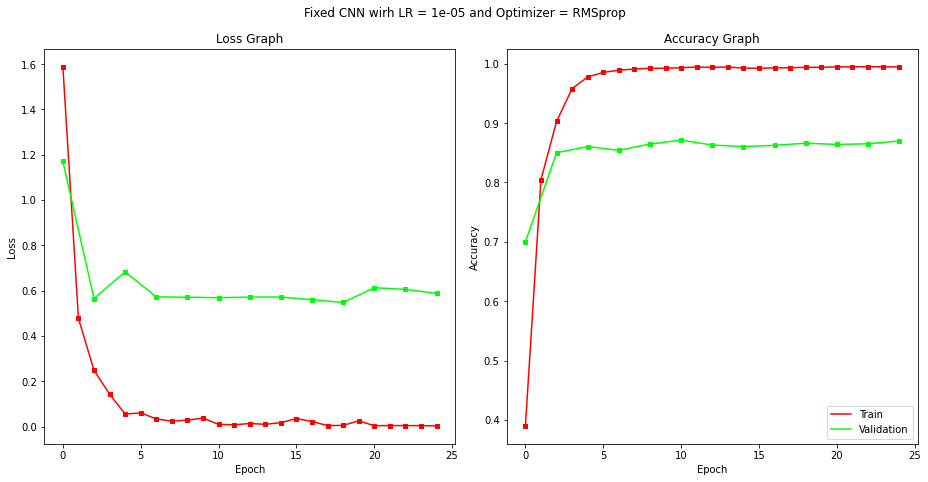

Min Loss: Train: 0.002939, Val: 0.547616
Max Accuracy: Train: 0.995073, Val: 0.871369


In [0]:
meta = 'Fixed CNN wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
result = Validation(net,test_dataset,test_dataloader)

Pre-Trainined net (Fixed FC Layer)

In [0]:
net = alexnet(pretrained=True) # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

net = FreezeNetwork(net,0)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Freezing: 0. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
54,947,941 training parameters.
0.96 ration trainable/total.


In [0]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.8628997802734375
Step 10, Loss 1.9646987915039062
*** Validation Accuracy: 0.6996887966804979 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.7418331503868103
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.3488953709602356
Step 40, Loss 0.27640631794929504
*** Validation Accuracy: 0.850103734439834 ***
Starting epoch 4/25, LR = [1e-05]
Step 50, Loss 0.14845578372478485
Starting epoch 5/25, LR = [1e-05]
Step 60, Loss 0.07620744407176971
Step 70, Loss 0.05115807428956032
*** Validation Accuracy: 0.8604771784232366 ***
Starting epoch 6/25, LR = [1e-05]
Step 80, Loss 0.03912018984556198
Starting epoch 7/25, LR = [1e-05]
Step 90, Loss 0.04759141802787781
Step 100, Loss 0.029947413131594658
*** Validation Accuracy: 0.854253112033195 ***
Starting epoch 8/25, LR = [1e-05]
Step 110, Loss 0.02365613356232643
Starting epoch 9/25, LR = [1e-05]
Step 120, Loss 0.011523986235260963
Step 130, Loss 0.015534767881035805
*** Validation Accuracy: 0.8646265560165975 ***
Starting epo

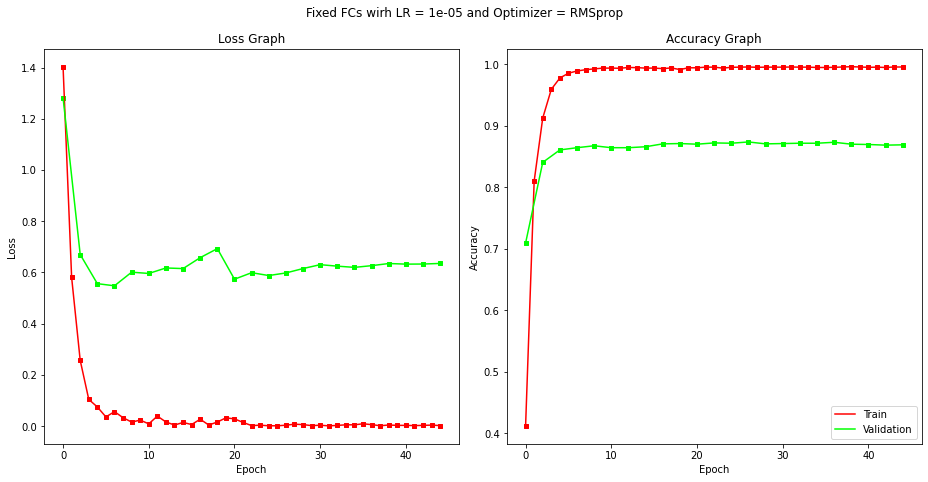

Min Loss: Train: 0.001229, Val: 0.547968
Max Accuracy: Train: 0.995851, Val: 0.873444


In [0]:
meta = 'Fixed FCs wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
result = Validation(net,test_dataset,test_dataloader)

*** Validation Accuracy: 0.006221914967162115 ***


Augmented Dataset

In [0]:
'''in any epoch the dataloader will apply a fresh set of random operations “on the fly”.
So instead of showing the exact same items at every epoch,
you are showing a variant that has been changed in a different way.
So after three epochs, you would have seen three random variants of each item in a dataset.'''

# Define transforms for training phase
angle = 180
p = 0.85
transformations = [transforms.RandomHorizontalFlip(p=p), transforms.RandomRotation([-angle,angle]), transforms.RandomVerticalFlip(p=p), transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)]
train_transform = transforms.Compose([transforms.RandomChoice(transformations),
                                      transforms.Resize(256),      
                                      transforms.CenterCrop(224),                         
                                                                   
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

PrepareDataset()

net = alexnet(pretrained=True) # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

#net = FreezeNetwork(net,0)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Train Dataset: 3856
Valid Dataset: 1928
Train/Valid Dataset Proportion: 2.0 (Required: 2)
Test Dataset: 2893


In [0]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/15, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 5.122612953186035
Step 10, Loss 2.38702392578125
*** Validation Accuracy: 0.649896265560166 ***
Starting epoch 2/15, LR = [1e-05]
Step 20, Loss 0.7726141810417175
Starting epoch 3/15, LR = [1e-05]
Step 30, Loss 0.48521414399147034
Step 40, Loss 0.34560784697532654
*** Validation Accuracy: 0.8195020746887967 ***
Starting epoch 4/15, LR = [1e-05]
Step 50, Loss 0.11837684363126755
Starting epoch 5/15, LR = [1e-05]
Step 60, Loss 0.08531393855810165
Step 70, Loss 0.06751786172389984
*** Validation Accuracy: 0.8558091286307054 ***
Starting epoch 6/15, LR = [1e-05]
Step 80, Loss 0.030459363013505936
Starting epoch 7/15, LR = [1e-05]
Step 90, Loss 0.027063755318522453
Step 100, Loss 0.03589899465441704
*** Validation Accuracy: 0.8558091286307054 ***
Starting epoch 8/15, LR = [1e-05]
Step 110, Loss 0.00919569656252861
Starting epoch 9/15, LR = [1e-05]
Step 120, Loss 0.00752105750143528
Step 130, Loss 0.014699619263410568
*** Validation Accuracy: 0.8558091286307054 ***
Starting epoc

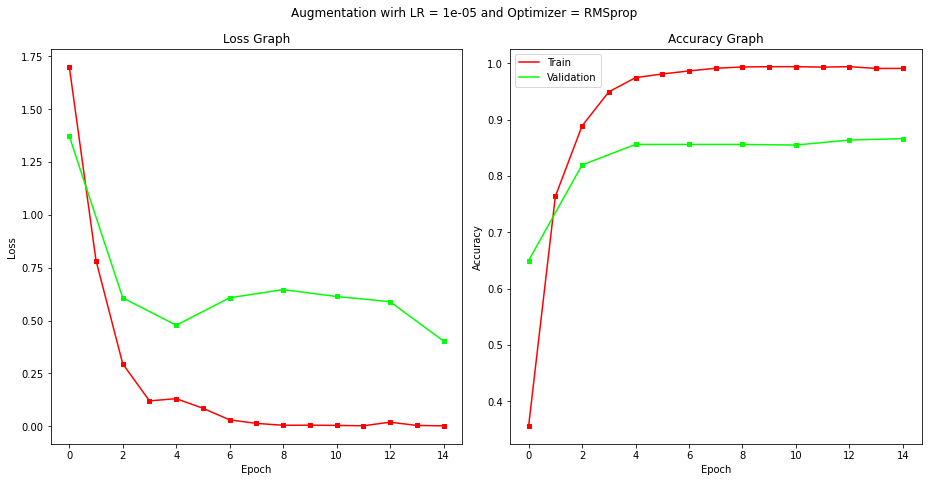

Min Loss: Train: 0.002091, Val: 0.403174
Max Accuracy: Train: 0.993776, Val: 0.866183


In [0]:
meta = 'Augmentation wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
result = Validation(net,test_dataset,test_dataloader)

*** Validation Accuracy: 0.8586242654683719 ***


Beyond AlexNet

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),                         
                                                                   
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

BATCH_SIZE = 256
train_dataset, val_dataset, test_dataset = PrepareDataset()
train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

Train Dataset: 3856
Valid Dataset: 1928
Train/Valid Dataset Proportion: 2.0 (Required: 2)
Test Dataset: 2893


VGG16

In [0]:
from torchvision.models import vgg16
net = vgg16(pretrained=True)

net.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 2024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(2024, NUM_CLASSES),                   
                      nn.LogSoftmax(dim=1))

#Print the number of Weights
net = FreezeNetwork(net,-1)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

ERROR INPUT!! Received freeze = -1 ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
142,757,397 total parameters.
142,757,397 training parameters.
0 freezed parameters.
1.00 ratio training/total.


In [0]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.656562805175781
Step 10, Loss 4.410537242889404
Step 20, Loss 3.9733011722564697
Step 30, Loss 4.378515720367432
Step 40, Loss 3.308361768722534
Step 50, Loss 3.0514488220214844
Step 60, Loss 3.0354270935058594
Step 70, Loss 2.856940507888794
Step 80, Loss 2.971572160720825
Step 90, Loss 2.3249332904815674
Step 100, Loss 2.233081579208374
Step 110, Loss 1.5375125408172607
*** Validation Accuracy: 0.7489626556016598 ***
Starting epoch 2/35, LR = [0.001]
Step 120, Loss 1.711281657218933
Step 130, Loss 1.1767957210540771
Step 140, Loss 1.0624501705169678
Step 150, Loss 1.0547033548355103
Step 160, Loss 0.6182053685188293
Step 170, Loss 0.7246608734130859
Step 180, Loss 0.5064303278923035
Step 190, Loss 1.1204032897949219
Step 200, Loss 0.49148714542388916
Step 210, Loss 0.7406438589096069
Step 220, Loss 0.9811382293701172
Step 230, Loss 0.5670639276504517
Starting epoch 3/35, LR = [0.001]
Step 240, Loss 0.4567355215549469
Step 250, Loss 0.5100017786026001
Step 260, Loss 0.1

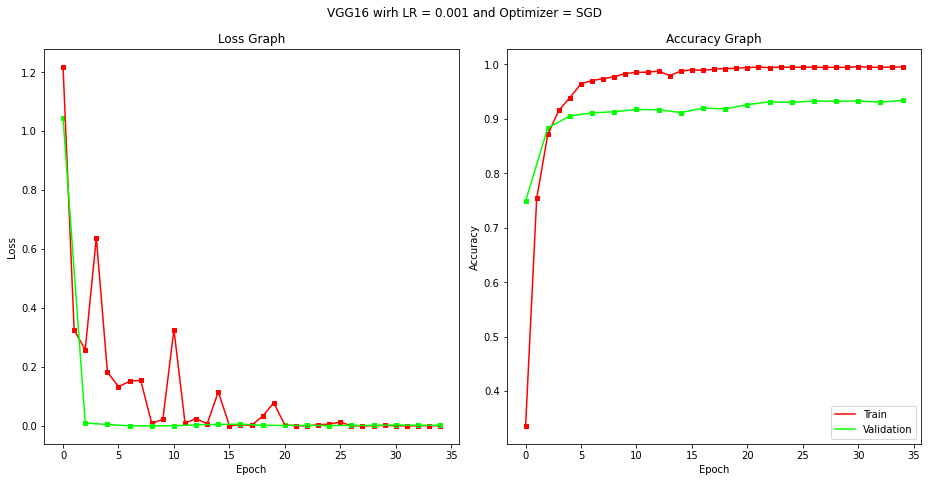

Min Loss: Train: 0.000020, Val: 0.000078
Max Accuracy: Train: 0.995591, Val: 0.933610


In [0]:
meta = 'VGG16 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
result = Validation(net,test_dataset,test_dataloader)

*** Validation Accuracy: 0.9305219495333564 ***


RESNET18

In [0]:
from torchvision.models import resnet18
from collections import OrderedDict

net = resnet18(pretrained=True)

#Add FC Layer
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096,NUM_CLASSES)),
    ('output', nn.LogSoftmax(dim=1))
]))

net.fc = fc

#Print the number of Weights
net = FreezeNetwork(net,-1)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

ERROR INPUT!! Received freeze = -1 ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
13,691,557 total parameters.
13,691,557 training parameters.
0 freezed parameters.
1.00 ratio training/total.


In [0]:
net, test, valid, best_acc = Training(net)

Starting epoch 1/35, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.605696678161621
Step 10, Loss 4.172549724578857
*** Validation Accuracy: 0.18205394190871368 ***
Starting epoch 2/35, LR = [0.001]
Step 20, Loss 3.6618683338165283
Starting epoch 3/35, LR = [0.001]
Step 30, Loss 3.4592642784118652
Step 40, Loss 3.1043007373809814
*** Validation Accuracy: 0.33350622406639 ***
Starting epoch 4/35, LR = [0.001]
Step 50, Loss 2.915722131729126
Starting epoch 5/35, LR = [0.001]
Step 60, Loss 2.7712557315826416
Step 70, Loss 2.8719561100006104
*** Validation Accuracy: 0.4823651452282158 ***
Starting epoch 6/35, LR = [0.001]
Step 80, Loss 2.5874195098876953
Starting epoch 7/35, LR = [0.001]
Step 90, Loss 2.5946271419525146
Step 100, Loss 2.304877519607544
*** Validation Accuracy: 0.5980290456431535 ***
Starting epoch 8/35, LR = [0.001]
Step 110, Loss 2.221453905105591
Starting epoch 9/35, LR = [0.001]
Step 120, Loss 2.0997676849365234
Step 130, Loss 2.0786073207855225
*** Validation Accuracy: 0.6436721991701245 ***
Starting epoch 10/35, LR = [0

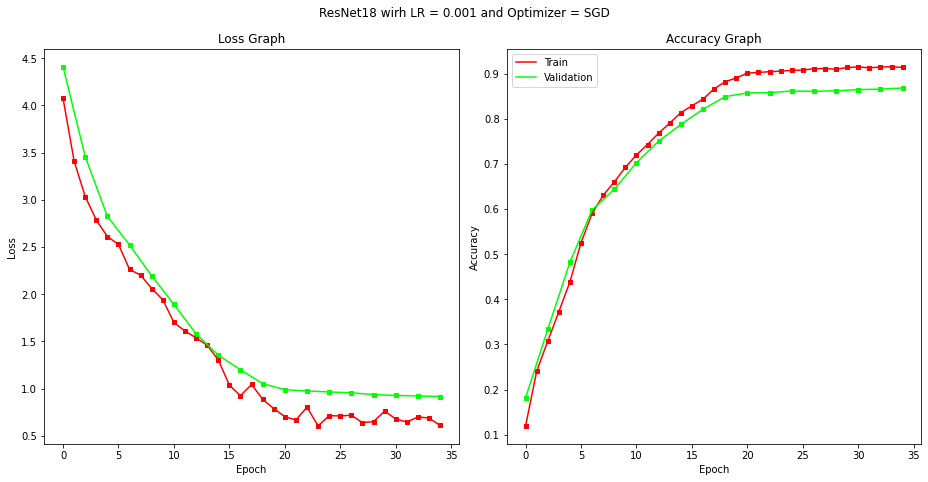

Min Loss: Train: 0.605167, Val: 0.915262
Max Accuracy: Train: 0.915456, Val: 0.868257


In [0]:
meta = 'ResNet18 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)

In [0]:
result = Validation(net,test_dataset,test_dataloader)

*** Validation Accuracy: 0.8724507431731766 ***
